# Convert ASCII Grid File to Cloud Optimised GeoTIFF

Downloads a zipped ASCII grid elevation file and exports it as a COG.

The zip file contains:
1. The raster data (.asc file)
2. The data's projection (.prj file)
3. A metadata html file (which we'll ignore)

### Load packages

In [26]:
# import boto3
import io
import os
import pathlib
import rasterio.crs
import requests
import zipfile

from matplotlib import pyplot
from rasterio.io import MemoryFile
from rio_cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles


### Settings

In [27]:
# the URL of the elevation data to download
url = "https://portal.spatial.nsw.gov.au/download/dem/56/Sydney-DEM-AHD_56_5m.zip"

# the path to save the images to
output_path = "./data"

download_path = os.path.join(output_path, "downloaded")
converted_path = os.path.join(output_path, "converted")

# create required data directories (if required)
pathlib.Path(download_path).mkdir(parents=True, exist_ok=True)
pathlib.Path(converted_path).mkdir(exist_ok=True)

### Download file

...and extract its contents into a list of in-memory files

In [28]:
%%time
# download zipfile
response = requests.get(url)         

CPU times: user 392 ms, sys: 195 ms, total: 587 ms
Wall time: 3.97 s


In [29]:
%%time
# extract each file from zipfile & add to list of (filename, file-like object) pairs
file_list = list()
with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
    for zipinfo in thezip.infolist():
        with thezip.open(zipinfo) as thefile:
            file_list.append((zipinfo.filename, thefile.read()))   

CPU times: user 2.8 s, sys: 346 ms, total: 3.14 s
Wall time: 3.17 s


### Load raster file & get it's coordinate system

Also, save files to disk for testing (not required for conversion to COG)

In [30]:
%%time
image = None
crs = None
output_file_name = None

for file in file_list:
    file_name = file[0]
    file_obj = file[1]

    # get raster as an in-memory file.
    if file_name.endswith(".asc"):
        image = MemoryFile(file_obj)
        output_file_name = file_name.replace(".asc", ".tif")

    # get well known text coordinate system
    if file_name.endswith(".prj"):
        proj_string = file_obj.decode("utf-8")
        crs = rasterio.crs.CRS.from_wkt(proj_string)

    # save file to disk
    with open(os.path.join(download_path, file_name), "wb") as f:
        f.write(file_obj)

CPU times: user 1.31 ms, sys: 293 ms, total: 294 ms
Wall time: 1.17 s


### Display the ASCII grid file

TypeError: Image data of dtype |S1 cannot be converted to float

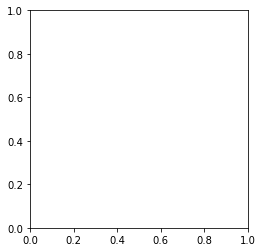

In [33]:
pyplot.imshow(image.read(0), cmap='pink')
pyplot.show()

### Convert to COG

Take the raster file & it's coordinate system and convert to a cloud optimised geotiff (COG) using 

In [ ]:
# set Sydney map bounds (in lat/long)

x_min = 150.45
x_max = 151.45
y_min = -34.15
y_max = y_min + (map_height / map_width) * (x_max - x_min)

bounds = dict(x_range = (x_min, x_max), y_range = (y_min, y_max))

# plot the points
cvs = datashader.Canvas(plot_width=map_width, plot_height=map_height, **bounds)
agg = cvs.points(df, 'x', 'y', datashader.count())

tf.set_background(tf.shade(agg.where(agg > 0), cmap=colorcet.fire), "black")

In [ ]:
# set Inner Sydney map bounds (in lat/long)

x_min = 150.8
x_max = 151.3
y_min = -34.0
y_max = y_min + (map_height / map_width) * (x_max - x_min)

bounds = dict(x_range = (x_min, x_max), y_range = (y_min, y_max))

# plot the points
cvs = datashader.Canvas(plot_width=map_width, plot_height=map_height, **bounds)
agg = cvs.points(df, 'x', 'y', datashader.count())

tf.set_background(tf.shade(agg.where(agg > 0), cmap=colorcet.blues), "white")

In [ ]:
sizes  = dict(width=plot_width, height=int(plot_width*0.5))
opts   = dict(xaxis=None, yaxis=None, bgcolor="black", **sizes)
points = hv.Points(df, ['x', 'y'])
dynspread(datashade(points, cmap=["red", "yellow"], **sizes)).options(**opts)